In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import matplotlib as mpl
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown, utils as system_utils

import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0

In [ ]:
def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    sigma, rho, beta = gs

    x, y, z = true

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    sigma, rho, beta = cs

    x, y, z = nudged

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


# System evolution parameters
sigma, rho, beta = g1, g2, g3 = 10, 28, 8 / 3
c1, c2, c3 = g1, g2, g3
c1 *= 1.1
c2 *= 0.9
c3 *= 0.9
mu = 20

gs = jnp.array([g1, g2, g3])
cs = jnp.array([c1, c2, c3])

true0, assimilated0 = get_initial_values()

observed_slice = jnp.s_[:2]
observed_mask = system_utils.mask_from_slice(observed_slice, true0.shape)
system = System_ModelKnown(mu, gs, cs, observed_mask, assimilated_ode, true_ode)

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)
optimizer = optax.adam(1e-1)
optimizer = optim.OptaxWrapper(system, optimizer)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 1000
t_relax = 1

true_solver = solver
trues, tls_ = true_solver.solve_true(true0, T0, Tf, dt)

true_observed = trues[:, system.observed_mask]

cs, u_errors, tls, assimilateds = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer=optimizer,
    return_all=True,
    parameter_update_option=utils.ParameterUpdateOption.mean_gradient,
)

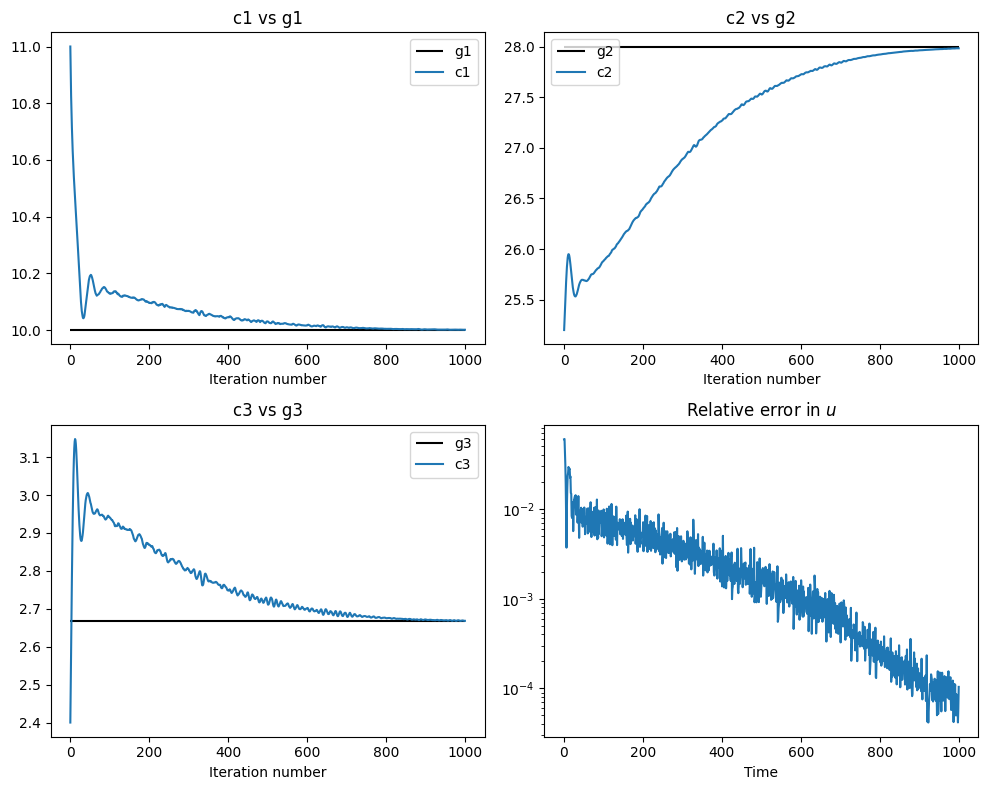

In [ ]:
fig, axs = plot.plot(cs.T[0], cs.T[1], cs.T[2], u_errors, g1, g2, g3, tls)
plt.show()

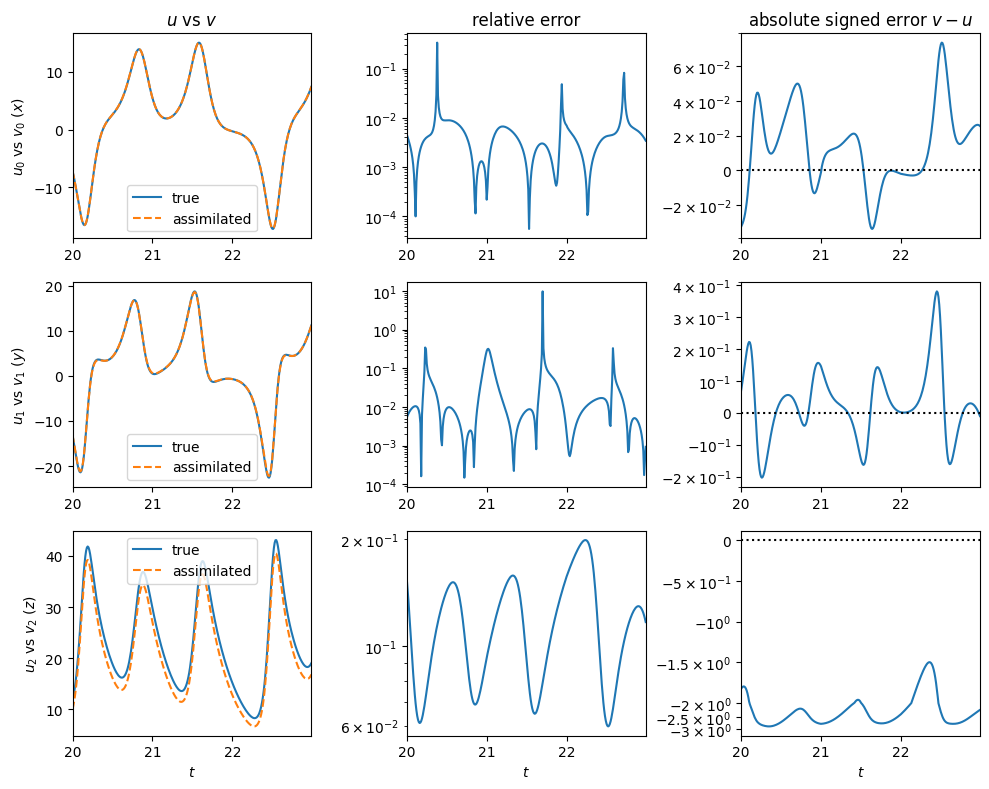

In [ ]:
tn, n = trues.shape
tls = jnp.arange(tn) * dt

start, end = 20, 23
start_idx, end_idx = int(start / dt), int(end / dt)
s_ = jnp.s_[start_idx:end_idx]

fig, axs = plt.subplots(3, 3, figsize=(10, 8))

axs[0, 0].set_title("$u$ vs $v$")
for i, (true, assimilated, ax) in enumerate(
    zip(trues.T, assimilateds.T, axs[:, 0])
):
    ax.plot(tls[s_], true[s_], label="true")
    ax.plot(tls[s_], assimilated[s_], label="assimilated", ls="--")
    ax.set_xlim(tls[s_][0], tls[s_][-1])
    ax.legend()

axs[0, 1].set_title("relative error")
for i, (true, assimilated, ax) in enumerate(
    zip(trues.T, assimilateds.T, axs[:, 1])
):
    ax.plot(
        tls[s_],
        abs(true[s_] - assimilated[s_]) / abs(true[s_]),
        label="relative error",
    )
    ax.set_xlim(tls[s_][0], tls[s_][-1])
    ax.set_yscale("log")

axs[0, 2].set_title("absolute signed error $v - u$")
for i, (true, assimilated, ax) in enumerate(
    zip(trues.T, assimilateds.T, axs[:, 2])
):
    ax.set_xlim(tls[s_][0], tls[s_][-1])
    ax.plot(
        tls[s_],
        (assimilated[s_] - true[s_]),
        label="absolute signed error",
    )
    ax.hlines(0, *ax.get_xlim(), colors="black", ls=":")
    ax.set_yscale("symlog")
    ax.yaxis.set_major_locator(mpl.ticker.AutoLocator())

[
    ax.set_ylabel(rf"$u_{{{i}}}$ vs $v_{{{i}}}$ (${var}$)")
    for i, (ax, var) in enumerate(zip(axs[:, 0], ("x", "y", "z")))
]
[ax.set_xlabel("$t$") for ax in axs[-1]]

fig.tight_layout()
plt.show()

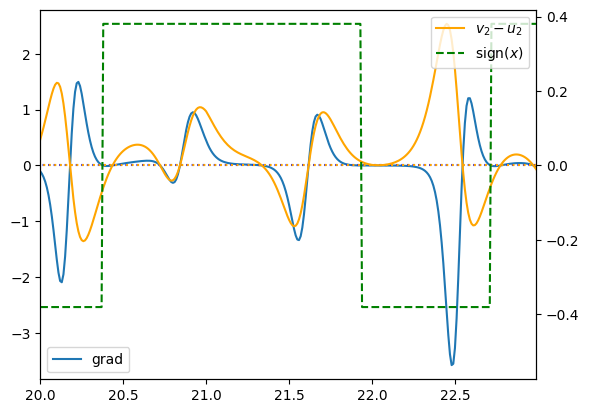

In [ ]:
tn, n = trues.shape
tls = jnp.arange(tn) * dt

u2 = true_observed[:, 1]
x = v1 = assimilateds[:, 0]
y = v2 = assimilateds[:, 1]
z = v3 = assimilateds[:, 2]
c_beta = cs[:, 2]
c_beta = c_beta[0]

grad = -1 / mu * (v2 - u2) * (-x * z / c_beta)

fig, ax = plt.subplots(1, 1)

ax.plot(tls[s_], grad[s_], label="grad")
ax.hlines(0, *ax.get_xlim(), colors="blue", ls=":")
ax.legend(loc="lower left")

ax = ax.twinx()
ax.plot(tls[s_], (v2 - u2)[s_], color="orange", label="$v_2 - u_2$")
ax.hlines(0, *ax.get_xlim(), colors="orange", ls=":")
ax.plot(
    tls[s_],
    np.sign(x[s_]) * abs((v2 - u2)[s_]).max(),
    color="green",
    label=r"$\text{sign}(x)$",
    ls="--",
)
ax.legend(loc="upper right")

ax.set_xlim(tls[s_][0], tls[s_][-1])
ylims = plot.align_zeros([ax.get_ylim() for ax in fig.axes])
[ax.set_ylim(ylim) for ax, ylim in zip(fig.axes, ylims)]

plt.show()